In [2]:
import random
import numpy as np
import shapely
from shapely.geometry import Point, LineString
from matplotlib import pyplot as plt
import anytree
from IPython.display import IFrame
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
import osmnx as ox
import pandas as pd
import geopandas as gpd
ox.config(use_cache=True, log_console=False)
from descartes import PolygonPatch
from sklearn.datasets import make_blobs

Usando la bilioteca osmnx que es una API para usar *Open Street Maps*  podemos obtener todos los nodos de la gráfica de de la red de autos en los siguientes municipios

In [3]:
G_1 = ox.graph_from_place("Cuernavaca, Morelos, Mexico", network_type="drive",)
G_2 = ox.graph_from_place("Jiutepec, Morelos, Mexico", network_type="drive",)
G_3 = ox.graph_from_place("Temixco, Morelos, Mexico", network_type="drive",)
G_4 = ox.graph_from_place("Xochitepec, Morelos, Mexico", network_type="drive",)
G_5 = ox.graph_from_place("Emiliano Zapata, Morelos, Mexico", network_type="drive",)

Obtengamos el poligono del municipio de Cuernavaca

In [4]:
gdf = ox.geocode_to_gdf("Cuernavaca, Morelos, Mexico")
gdf.head()

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"POLYGON ((-99.34201 18.92252, -99.33994 18.922...",19.02465,18.841911,-99.180544,-99.342012,258936152,relation,5605731,18.933132,-99.259958,"Cuernavaca, Morelos, Mexico",boundary,administrative,0.598514


<AxesSubplot:>

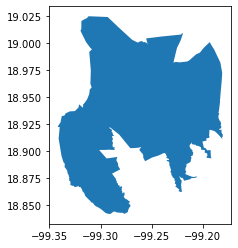

In [5]:
gdf.plot()

A partir de las gráficas que tenemos vamos a extraer solo los nodos y vamos a juntarlos todos en un geodataframe

In [8]:
G_1

In [9]:
xy = []
for G in [G_1, G_2, G_3, G_4, G_5 ]:
    xy= xy + [(data['x'], data['y']) for node, data in G.nodes(data=True)] 

In [10]:
x, y = list(zip(*xy))

In [12]:
gdf_nodos = gpd.GeoDataFrame(data={'x':x, 'y':y})
gdf_nodos.crs = gdf.crs
gdf_nodos.name = 'nodes'
gdf_nodos['geometry'] = gdf_nodos.apply(lambda row: Point((row['x'], row['y'])), axis=1)
gdf_nodos.head()

/home/miguel/anaconda3/envs/geoselectos/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  


,x,y,geometry
0,-99.213584,18.980180,POINT (-99.21358 18.98018)
1,-99.222702,18.964102,POINT (-99.22270 18.96410)
2,-99.217290,18.963633,POINT (-99.21729 18.96363)
3,-99.215480,18.964791,POINT (-99.21548 18.96479)
4,-99.213125,18.961792,POINT (-99.21313 18.96179)


In [25]:
gdf_nodos.shape

(34617, 3)

<AxesSubplot:>

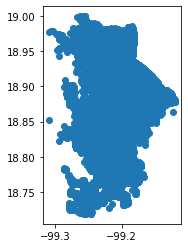

In [14]:
gdf_nodos.plot()

Vamos a crear un mapa que contenga a los puntos y al polygono del municipio de cuernavaca

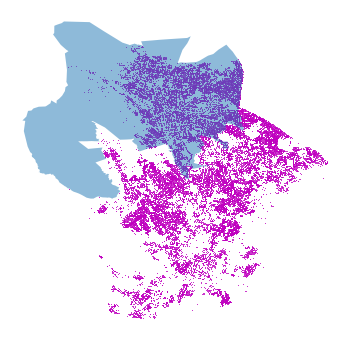

In [13]:
o_val, s_val, e_val, n_val = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))

x_pol, y_pol = gdf['geometry'][0].exterior.xy
ax.fill (x_pol, y_pol, alpha=0.5)
ax.scatter(x=gdf_nodos['x'], y=gdf_nodos['y'], s=1, c='m', linewidth=0, zorder=1)



ax.axis('off')
plt.show()

¿ Como tendríamos que hacer para intersectar el poligono con los puntos ?

In [15]:
%%time
res_bool = gdf_nodos['geometry'].apply(lambda l: gdf['geometry'][0].contains(l))

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s


In [17]:
gdf_nodos[res_bool]

,x,y,geometry
0,-99.213584,18.980180,POINT (-99.21358 18.98018)
1,-99.222702,18.964102,POINT (-99.22270 18.96410)
2,-99.217290,18.963633,POINT (-99.21729 18.96363)
3,-99.215480,18.964791,POINT (-99.21548 18.96479)
4,-99.213125,18.961792,POINT (-99.21313 18.96179)
...,...,...,...
12475,-99.192611,18.933909,POINT (-99.19261 18.93391)
12476,-99.223141,18.946133,POINT (-99.22314 18.94613)
12477,-99.263652,18.983318,POINT (-99.26365 18.98332)
12478,-99.251523,18.955869,POINT (-99.25152 18.95587)


Vamos hacerlo con un índice espacial en geopandas 

In [18]:
sindex = gdf_nodos.sindex


Veamos que es este indice espacial

In [19]:
sindex

rtree.index.Index(bounds=[-99.3086227, 18.7187848, -99.1201486, 18.9994833], size=34617)

Tomemos ahora la interseccion entre el índice y el bounding box del poligono 

In [20]:
index_intersec_bounds = sindex.intersection(gdf['geometry'][0].bounds)
index_intersec_bounds

<generator object Index._get_ids at 0x7eff3301d1d0>

In [21]:
possible_matches_index = list(index_intersec_bounds)
possible_matches_index

[12860,
 12683,
 15229,
 12684,
 15205,
 12685,
 12902,
 12904,
 12919,
 13785,
 16453,
 16455,
 16456,
 14296,
 12761,
 18891,
 14280,
 15928,
 14294,
 14295,
 18267,
 14656,
 14690,
 14689,
 14688,
 18475,
 33695,
 13070,
 13085,
 13106,
 13141,
 13153,
 17324,
 13010,
 13039,
 13059,
 12965,
 17268,
 12987,
 14996,
 14403,
 16487,
 14407,
 784,
 779,
 12725,
 14405,
 12704,
 5355,
 12735,
 12741,
 12722,
 777,
 769,
 15214,
 12092,
 6091,
 677,
 775,
 776,
 2805,
 6090,
 5572,
 6011,
 10501,
 5914,
 5913,
 2808,
 5573,
 2813,
 2814,
 2817,
 2820,
 2821,
 2822,
 6098,
 2826,
 2825,
 2827,
 5338,
 2830,
 2831,
 2832,
 6008,
 2835,
 6015,
 2838,
 2839,
 6014,
 2946,
 2947,
 10189,
 2844,
 2843,
 6017,
 6016,
 774,
 11345,
 5339,
 2955,
 10190,
 713,
 2846,
 2962,
 2963,
 5996,
 2849,
 2966,
 2970,
 6878,
 875,
 5779,
 5709,
 10968,
 4522,
 10969,
 10965,
 10964,
 11730,
 11731,
 4531,
 11732,
 11850,
 11851,
 890,
 7048,
 10972,
 11733,
 6890,
 10983,
 7053,
 11004,
 11005,
 5710,
 117

Obtenemos los puntos que se intersectan y vemos aquellos que se intersecten con la geometria del poligono

In [22]:
possible_matches = gdf_nodos.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(gdf['geometry'][0])]####Comparacion con el poligono

In [23]:
points_within_geometry = precise_matches
points_outside_geometry = gdf_nodos[~gdf_nodos.isin(points_within_geometry)]

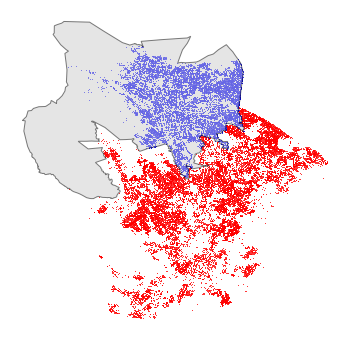

In [24]:
fig, ax = plt.subplots(figsize=(6,6))

patch = PolygonPatch(gdf['geometry'][0], fc='#cccccc', ec='k', alpha=0.5, zorder=3)
ax.add_patch(patch)

ax.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=2)
    

ax.axis('off')
plt.show()

In [22]:
points_within_geometry.shape

(12482, 3)

In [24]:
points_outside_geometry.shape

(34617, 3)

Podemos incluso dividir nuestro poligono para obtener las intersecciones internas y poder hacer una comparación con los nodos de la red 

In [27]:
geometry_cut = ox.utils_geo._quadrat_cut_geometry(gdf['geometry'][0], quadrat_width=0.01)

In [28]:
type(geometry_cut)

shapely.geometry.multipolygon.MultiPolygon

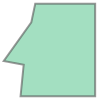

In [29]:
geometry_cut[0]

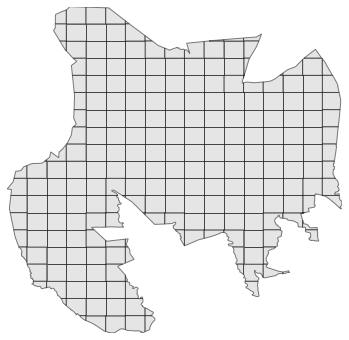

In [30]:
fig, ax = plt.subplots(figsize=(6,6))
for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(o_val, e_val)
ax.set_ylim(s_val, n_val)
ax.axis('off')

plt.show()

In [33]:
points_within_geometry_df = pd.DataFrame()
count_dics =[]
for poly in geometry_cut:   
    poly = poly.buffer(1e-14).buffer(0)
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = gdf_nodos.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    count_dics.append({'geometry': poly ,'Puntos_dentro':precise_matches.shape[0] })
    points_within_geometry_df = points_within_geometry_df.append(precise_matches)

In [32]:
points_within_geometry_df

,x,y,geometry
6211,-99.308623,18.977751,POINT (-99.30862 18.97775)
12147,-99.306475,18.978323,POINT (-99.30648 18.97832)
5074,-99.302904,18.979049,POINT (-99.30290 18.97905)
12148,-99.299136,18.974402,POINT (-99.29914 18.97440)
7403,-99.295365,18.974862,POINT (-99.29537 18.97486)
...,...,...,...
6726,-99.194454,18.898112,POINT (-99.19445 18.89811)
5146,-99.197208,18.898303,POINT (-99.19721 18.89830)
4601,-99.197358,18.898340,POINT (-99.19736 18.89834)
6734,-99.194635,18.898944,POINT (-99.19464 18.89894)


In [37]:
df_polygons= gpd.GeoDataFrame(count_dics)

<AxesSubplot:>

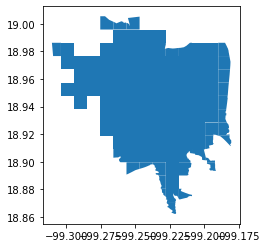

In [40]:
df_polygons[df_polygons['Puntos_dentro']!=0].plot()

In [40]:
points_within_geometry_df = points_within_geometry_df.drop_duplicates(subset=['x', 'y'])
points_outside_geometry_df = gdf_nodos[~gdf_nodos.isin(points_within_geometry_df)]

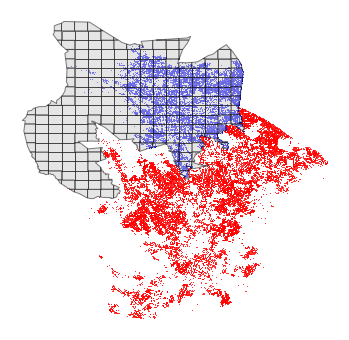

In [43]:
fig, ax = plt.subplots(figsize=(6,6))

for polygon in geometry_cut:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)

ax.scatter(x=points_outside_geometry_df['x'], y=points_outside_geometry_df['y'], s=1, c='r', linewidth=0, zorder=1)
ax.scatter(x=points_within_geometry_df['x'], y=points_within_geometry_df['y'], s=1, c='b', linewidth=0, zorder=2)
    

ax.axis('off')
plt.show()

¿ Cuando nos sirve tener la segunda versión?